# Package

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg  
import seaborn as sns
from scipy.stats import norm
from scipy.stats import shapiro
from statsmodels.stats.stattools import jarque_bera
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from arch import arch_model
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg

# Importation des données

In [2]:
# Lire le fichier brut
with open("lbl-tcp-3.tcp", "r", encoding="latin-1") as f:
    lignes = f.readlines()

# Afficher quelques lignes pour voir la structure
for i, ligne in enumerate(lignes[:20]):  # juste les 20 premières
    print(i, ligne.strip())

0 759103800.008185 1 2 23 2436 1
1 0.010445 2 1 2436 23 2
2 0.023775 1 2 23 2436 2
3 0.026558 2 1 2436 23 1
4 0.029002 3 4 3930 119 42
5 0.032439 4 3 119 3930 15
6 0.049618 1 2 23 2436 1
7 0.052431 5 2 14037 23 2
8 0.056457 2 5 23 14037 2
9 0.057815 6 7 23 1502 414
10 0.072126 8 9 1023 513 0
11 0.098415 3 4 3930 119 55
12 0.104465 4 3 119 3930 15
13 0.122345 10 11 6000 2290 0
14 0.124490 7 6 1502 23 0
15 0.125228 2 1 2436 23 1
16 0.138935 1 2 23 2436 1
17 0.139950 12 13 1208 6000 64
18 0.140930 2 1 2436 23 1
19 0.146912 13 12 6000 1208 32


In [3]:
# Chargement brut : 6 colonnes, séparateur = espaces ----
path = "lbl-tcp-3.tcp"

colnames = ["ts", "src_id", "dst_id", "src_port", "dst_port", "val"]
df = pd.read_csv(
    path,
    sep=r"\s+",            # espaces multiples
    header=None,
    names=colnames,
    engine="python",
    dtype={
        "ts": float,
        "src_id": np.int64,
        "dst_id": np.int64,
        "src_port": np.int64,
        "dst_port": np.int64,
        "val": np.int64
    }
)

In [4]:
df.head()

,ts,src_id,dst_id,src_port,dst_port,val
0,7.591038e+08,1,2,23,2436,1
1,1.044500e-02,2,1,2436,23,2
2,2.377500e-02,1,2,23,2436,2
3,2.655800e-02,2,1,2436,23,1
4,2.900200e-02,3,4,3930,119,42


ts : un temps (soit un timestamp Unix en secondes, soit un temps relatif en secondes).

src_id / dst_id : identifiants d’hôtes (pas des IP, mais des numéros d’hôtes anonymisés).

src_port / dst_port : ports TCP source et destination.

val : c’est la métrique par événement. cette colonne correspond au compte de paquets (si chaque ligne est un agrégat).

In [5]:
df["val"].describe()

count    1.789995e+06
mean     1.363555e+02
std      2.388757e+02
min     -4.000000e+00
25%      0.000000e+00
50%      4.000000e+00
75%      1.250000e+02
max      1.460000e+03
Name: val, dtype: float64

In [7]:
# On doit donc analyser par paquet
# 1) Point de départ
t0 = df['ts'].min()

# 2) Intervalles de 10 s (fenêtres [0,10), [10,20), …, [7190,7200))
df['Interval'] = np.floor((df['ts'] - t0 - 1e-9) / 10).astype(int)

# 3) Garder seulement 720 intervalles (0..719)
df = df[df['Interval'].between(0, 719)]

In [8]:
# 4) Agrégation du nombre de paquets
#    Ici 'val' = taille/nb paquets par ligne → on fait la somme
packets_per_interval = df.groupby('Interval')['val'].sum()

# 5) Série complète de 720 valeurs
ts_series = packets_per_interval.reindex(range(720), fill_value=0).astype(int)

print("Nombre d'intervalles :", ts_series.shape[0])  # doit être 720
print(ts_series.head(20))


Nombre d'intervalles : 720
Interval
0     100198
1     128192
2     657319
3     165042
4     258717
5     131597
6     185611
7     168147
8     560904
9     262143
10    465752
11    845334
12    952408
13    822620
14    547602
15    527810
16    582430
17    605039
18    775739
19    871669
Name: val, dtype: int64


In [9]:
ts_series

Interval
0      100198
1      128192
2      657319
3      165042
4      258717
        ...  
715    401173
716    297623
717    202993
718    160664
719    293664
Name: val, Length: 720, dtype: int64

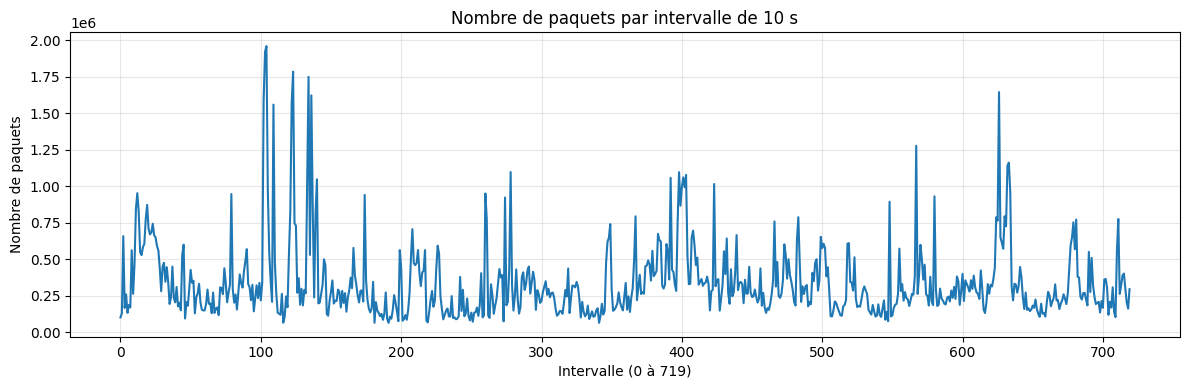

In [10]:
plt.figure(figsize=(12,4))
ts_series.plot()
plt.title("Nombre de paquets par intervalle de 10 s")
plt.xlabel("Intervalle (0 à 719)")
plt.ylabel("Nombre de paquets")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Construction du modèle auto-régressif AR(p)

In [11]:
# Essaie avec AR(1)
mod = AutoReg(ts_series, lags = 3)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                    val   No. Observations:                  720
Model:                     AutoReg(3)   Log Likelihood               -9803.217
Method:               Conditional MLE   S.D. of innovations         209736.883
Date:                Mon, 01 Sep 2025   AIC                          19616.433
Time:                        17:32:34   BIC                          19639.309
Sample:                             3   HQIC                         19625.266
                                  720                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.255e+05   1.48e+04      8.475      0.000    9.65e+04    1.55e+05
val.L1         0.5282      0.037     14.198      0.000       0.455       0.601
val.L2         0.0613      0.042      1.459      0.1

In [13]:
x = min(2, 1.5, 0.5)

print(x)

0.5


In [57]:
# AR avec choix du nombre de retards
# ============================================
# Étape 1 — Préparation des données
# ============================================
y = pd.Series(ts_series, dtype=float).dropna()
n = len(y)
h = int(0.1 * n)                 # 20% pour le test
y_train, y_test = y.iloc[:-h], y.iloc[-h:]
idx_train, idx_test = y_train.index, y_test.index
pmax = min(20, max(5, n // 10))  # borne prudente (modifiable)
K = 5                             # nb de splits pour backtesting

In [58]:
# ============================================
# Étape 2 — Évaluation AIC / BIC pour p = 1..pmax
# ============================================
ic_rows = []
for p in range(1, pmax+1):
    try:
        res = AutoReg(y_train, lags=p, old_names=False).fit()
        ic_rows.append({"p": p, "AIC": res.aic, "BIC": res.bic})
    except Exception:
        ic_rows.append({"p": p, "AIC": np.nan, "BIC": np.nan})
ic_df = pd.DataFrame(ic_rows)

In [59]:
ic_df.head()

,p,AIC,BIC
0,1,17749.747580,17763.164619
1,2,17721.245955,17739.129153
2,3,17691.579620,17713.925871
3,4,17664.566612,17691.372805
4,5,17639.337705,17670.600718


In [60]:
# Travail personnel 
s = pd.Series([10,25,30, 50, 70])
print(s)
idx = np.linspace(0, 5, 5, dtype=int)
print(idx)

0    10
1    25
2    30
3    50
4    70
dtype: int64
[0 1 2 3 5]


In [61]:
# Travail personnel 
idx[:3]
print(s[idx[:1]]) # Jusqu'à l'élément 0
print(s[idx[1]:idx[3]]) # A partir de l'élément 1 à 2

0    10
dtype: int64
1    25
2    30
dtype: int64


In [62]:
# ============================================
# Étape 3 — Backtesting dans le TRAIN (fenêtres extensibles) → CV_RMSE
# ============================================
def ts_cv_rmse_chunks(series: pd.Series, p: int, nchunks: int = 5):
    s = pd.Series(series).dropna()
    n = len(s)
    cuts = np.linspace(0, n, nchunks + 1, dtype=int)
    rmses = []
    for k in range(nchunks - 1):
        train = s.iloc[:cuts[k+1]]
        validation  = s.iloc[cuts[k+1]:cuts[k+2]]
        if len(train) <= p or len(validation) == 0:
            continue
        m = AutoReg(train, lags=p, old_names=False).fit()
        pred = m.forecast(steps=len(validation)); pred.index = validation.index
        rmses.append(np.sqrt(((validation - pred)**2).mean()))
    return float(np.mean(rmses)) if rmses else np.nan

cv_rows = [{"p": p, "CV_RMSE": ts_cv_rmse_chunks(y_train, p, nchunks=K)}
           for p in range(1, pmax+1)]
cv_df = pd.DataFrame(cv_rows)

Avec nchunks = 5 : 

Fold 1 : train = 0–20%, test = 20–40%

Fold 2 : train = 0–40%, test = 40–60%

Fold 3 : train = 0–60%, test = 60–80%

Fold 4 : train = 0–80%, test = 80–100%

In [63]:
# ============================================
# Étape 4 — Synthèse des résultats & choix de p
# ============================================
out = ic_df.merge(cv_df, on="p").sort_values("p").reset_index(drop=True)
print("Table des scores (p, AIC, BIC, CV_RMSE):")
print(out)

best_p_aic = out.loc[out["AIC"].idxmin(), "p"]
best_p_bic = out.loc[out["BIC"].idxmin(), "p"]
best_p_cv  = out.loc[out["CV_RMSE"].idxmin(), "p"]

print(f"\nChoix de p :  AIC={best_p_aic} | BIC={best_p_bic} | Backtesting(CV_RMSE)={best_p_cv}")

Table des scores (p, AIC, BIC, CV_RMSE):
     p           AIC           BIC        CV_RMSE
0    1  17749.747580  17763.164619  242082.342868
1    2  17721.245955  17739.129153  242153.275144
2    3  17691.579620  17713.925871  240713.216196
3    4  17664.566612  17691.372805  242131.272456
4    5  17639.337705  17670.600718  243112.439497
5    6  17610.864264  17646.580970  242583.792592
6    7  17586.335797  17626.503062  242666.434656
7    8  17561.145725  17605.760407  244591.760911
8    9  17534.737381  17583.796330  243239.629106
9   10  17509.128461  17562.628521  243588.657840
10  11  17482.693848  17540.631854  242324.875022
11  12  17453.771952  17516.144732  240943.794162
12  13  17422.816465  17489.620840  239536.872193
13  14  17397.838456  17469.071240  239559.611876
14  15  17371.507751  17447.165748  239134.816693
15  16  17344.431704  17424.511713  239369.919095
16  17  17317.240323  17401.739135  239847.812332
17  18  17291.070425  17379.984821  242175.261568
18  19  1

In [64]:
df.head()

,ts,src_id,dst_id,src_port,dst_port,val,Interval
3,0.026558,2,1,2436,23,1,0
4,0.029002,3,4,3930,119,42,0
5,0.032439,4,3,119,3930,15,0
6,0.049618,1,2,23,2436,1,0
7,0.052431,5,2,14037,23,2,0


In [65]:
# Travail personnel 
print(df.loc[3]) # 3è ligne, utile pour les index pas entier

ts             0.026558
src_id         2.000000
dst_id         1.000000
src_port    2436.000000
dst_port      23.000000
val            1.000000
Interval       0.000000
Name: 3, dtype: float64


In [66]:
# Travail personnel
df.iloc[3] # Par ordre d'apparition mais pas lié à l'index

ts             0.049618
src_id         1.000000
dst_id         2.000000
src_port      23.000000
dst_port    2436.000000
val            1.000000
Interval       0.000000
Name: 6, dtype: float64

In [67]:
# ============================================
# Étape 5 — Ajustement final (parcimonieux : BIC)
# ============================================
p_final = int(best_p_bic)
final = AutoReg(y_train, lags=p_final).fit()
print(f"\nRésumé du modèle final AR({p_final}):")
print(final.summary())


Résumé du modèle final AR(20):
                            AutoReg Model Results                             
Dep. Variable:                    val   No. Observations:                  648
Model:                    AutoReg(20)   Log Likelihood               -8596.425
Method:               Conditional MLE   S.D. of innovations         213125.358
Date:                Mon, 01 Sep 2025   AIC                          17236.849
Time:                        17:50:10   BIC                          17334.585
Sample:                            20   HQIC                         17274.818
                                  648                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.276e+04   2.37e+04      3.919      0.000    4.64e+04    1.39e+05
val.L1         0.5116      0.040     12.858      0.000       0.434       0.590
val.L2         0.061

In [68]:
# ============================================
# Étape 6 — Test final
# ============================================
pred_test = final.forecast(steps=len(y_test))
pred_test.index = y_test.index

# Erreur sur le jeu de test
rmse_test = np.sqrt(((y_test - pred_test) ** 2).mean())
print(f"RMSE test final: {rmse_test:.4f}")

RMSE test final: 164950.6008


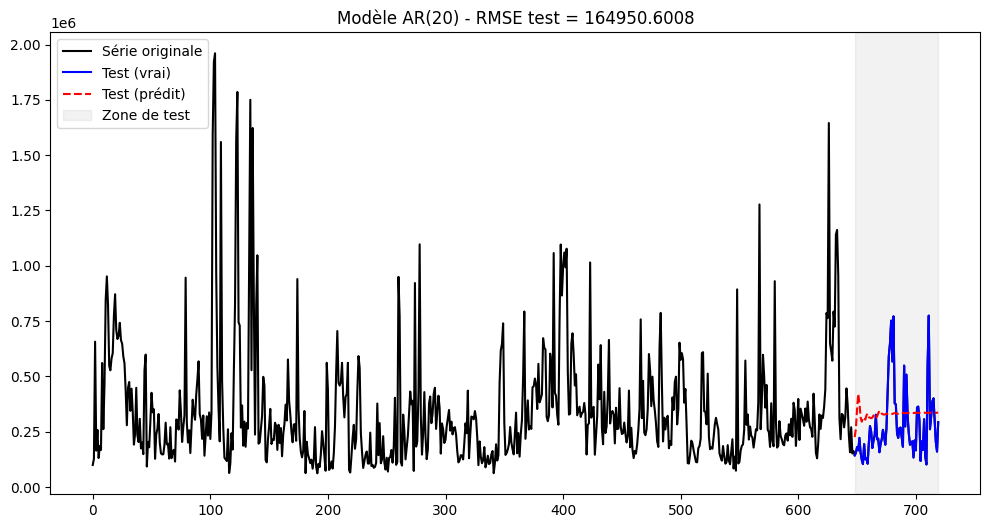

In [69]:
# Visualisation
plt.figure(figsize=(12,6))
plt.plot(y, label="Série originale", color="black")
plt.plot(y_test, label="Test (vrai)", color="blue")
plt.plot(pred_test, label="Test (prédit)", color="red", linestyle="--")
plt.axvspan(y_test.index[0], y_test.index[-1], color="grey", alpha=0.1, label="Zone de test")
plt.title(f"Modèle AR({p_final}) - RMSE test = {rmse_test:.4f}")
plt.legend()
plt.show()

La prévision suit juste l'allure au départ mais finalement, elle s'écarte énormément des valeurs réelles. Elle ne suit pas l'allure de la courbe. 

# 10 Analyse des résidus

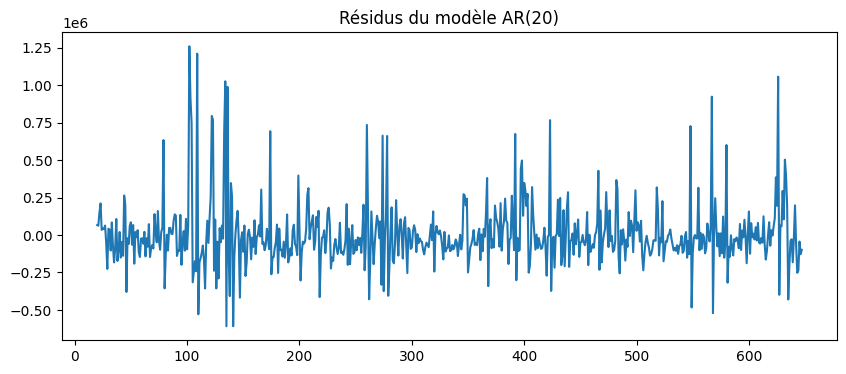

In [71]:
residuals = final.resid

plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title(f"Résidus du modèle AR({p_final})")
plt.show()

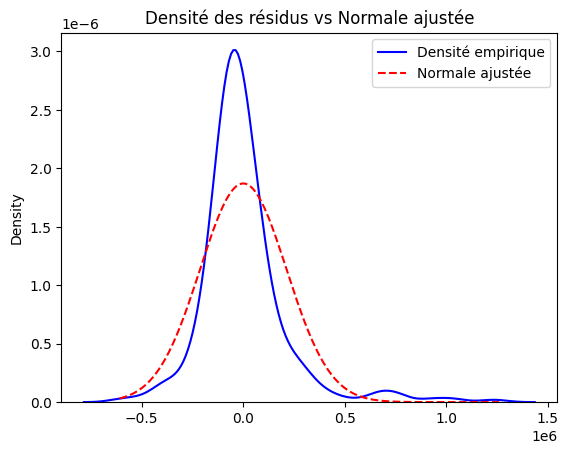

In [72]:

# moyenne et écart-type des résidus
mu, sigma = residuals.mean(), residuals.std()

# tracer la densité empirique
sns.kdeplot(residuals, label="Densité empirique", color="blue")

# tracer la densité normale estimée
x_vals = np.linspace(min(residuals), max(residuals), 200)
plt.plot(x_vals, norm.pdf(x_vals, mu, sigma), 'r--', label="Normale ajustée")

plt.title("Densité des résidus vs Normale ajustée")
plt.legend()
plt.show()


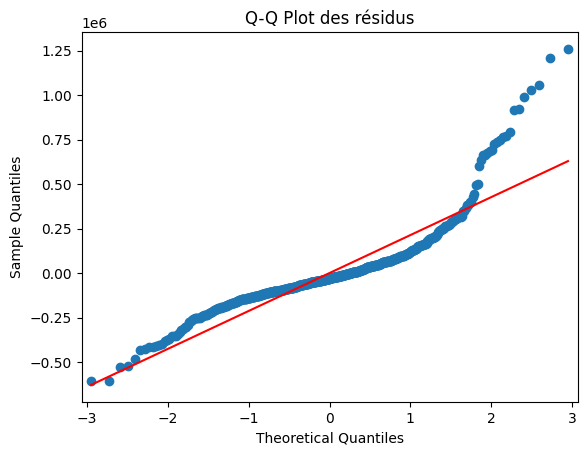

In [75]:
sm.qqplot(residuals, line='s')
plt.title("Q-Q Plot des résidus")
plt.show()

In [76]:
# Test de Shapiro-Wilk
shapiro_stat, shapiro_p = shapiro(residuals)
print("Test de Shapiro-Wilk :")
print(f"Statistique = {shapiro_stat:.4f}, p-value = {shapiro_p:.4f}")

# Test de Jarque-Bera
jb_stat, jb_p, skew, kurt = jarque_bera(residuals)
print("\nTest de Jarque-Bera :")
print(f"Statistique = {jb_stat:.4f}, p-value = {jb_p:.4f}")
print(f"Asymétrie (skewness) = {skew:.4f}, Kurtose = {kurt:.4f}")

Test de Shapiro-Wilk :
Statistique = 0.8295, p-value = 0.0000

Test de Jarque-Bera :
Statistique = 2078.5452, p-value = 0.0000
Asymétrie (skewness) = 1.9918, Kurtose = 10.9728


Les résidus ne sont pas distribués normalement. En effet, l'allure de la courbe de leur distribution s'écarte nettement de celle d'une Loi normale. Les tests de normalités confirment qu'on rejette l'hypothèse de normalité.  

La prévision reste valide mais l'inférence statistique ne l'est pas. çà veut dire que les intervvales de confiance autour des prévisions risquent d'être trop optimistes. (sous-estimation de l'incertitude). 

Dans ce cas, il est nécessaire de recourir à des modèles adaptés comme les modèles GARCH. 

Voyons d'abord pourquoi AR n'a pas bien marché.

# Etablir une stratégie d'amélioration du modèle AR

In [77]:
# Test de stationnarité
result = adfuller(y, autolag='AIC')

print("=== Test de Dickey-Fuller augmenté (ADF) ===")
print(f"Statistique ADF : {result[0]:.4f}")
print(f"p-value        : {result[1]:.4f}")
print("Valeurs critiques :")
for key, value in result[4].items():
    print(f"   {key}: {value:.4f}")

=== Test de Dickey-Fuller augmenté (ADF) ===
Statistique ADF : -11.3580
p-value        : 0.0000
Valeurs critiques :
   1%: -3.4395
   5%: -2.8656
   10%: -2.5689


On rejette H0 : la série n'est pas stationnaire. La série est donc déjà stationnaire. Ce qui veut dire que la raison de non normalité des résidus est à recherché.

D'après l'allure du graphique des résidus, il me semble qu'ils ne sont pas homoscedastiques. 

Voyons ce point de plus près. 

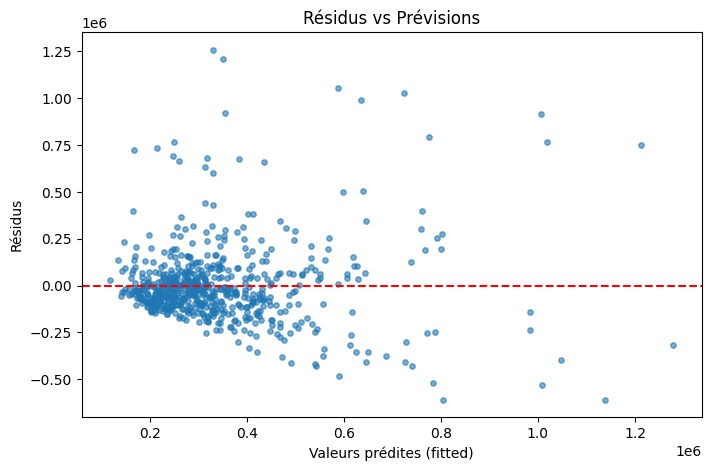

In [ ]:
# Vérification de l'homoscedasticité
fitted = final.fittedvalues   # valeurs prédites in-sample
resid = final.resid           # résidus du modèle

plt.figure(figsize=(8,5))
plt.scatter(fitted, resid, s=15, alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Valeurs prédites (fitted)")
plt.ylabel("Résidus")
plt.title("Résidus vs Prévisions")
plt.show()

Le nuage Résidus vs Prévisions montre une dispersion croissante, signe d’hétéroscédasticité (variance non constante). Le nouveau choix de p avec d'autres critères que BIC ne règle pas le problème. 

Un modèle ARCH/GARCH serait plus adapté.
Mais avant d’en tester un, il faut confirmer statistiquement l’hétéroscédasticité (ex. test d’Engle) et vérifier la spécification des résidus (ACF/PACF des résidus et de leurs carrés). 

In [79]:
# Tester l'homoscedasticité
resid = final.resid.dropna()
arch_stat, arch_pval, _, _ = het_arch(resid, nlags=12)

print("=== Test d'Engle ARCH ===")
print(f"Statistique : {arch_stat:.4f}")
print(f"p-value     : {arch_pval:.4f}")
print("H0 : pas d'effet ARCH (variance constante).")
print("Si p-value < 0.05 → hétéroscédasticité (ARCH) détectée.")

=== Test d'Engle ARCH ===
Statistique : 100.5957
p-value     : 0.0000
H0 : pas d'effet ARCH (variance constante).
Si p-value < 0.05 → hétéroscédasticité (ARCH) détectée.


Cela confirme une hétéroscédasticité conditionnelle : la variance des résidus n’est pas constante.

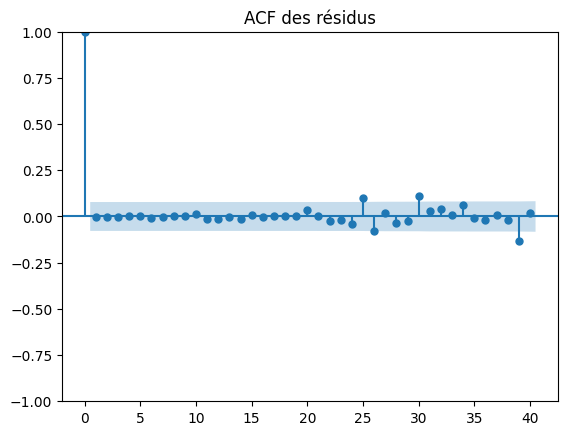

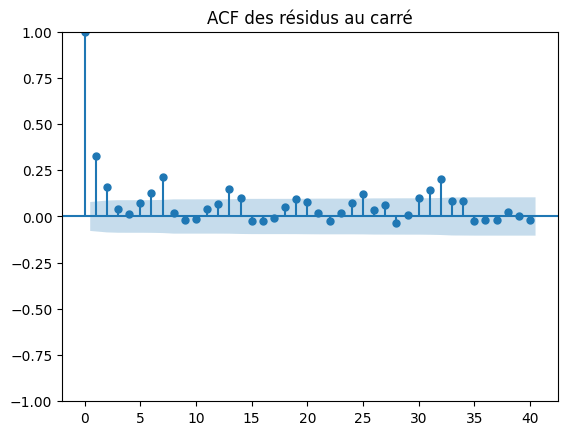

In [80]:
# Présenter l'autocorrélation significative
# ACF des résidus
plot_acf(resid, lags=40)
plt.title("ACF des résidus")
plt.show()

# ACF des résidus au carré
plot_acf(resid**2, lags=40)
plt.title("ACF des résidus au carré")
plt.show()

ACF des résidus au carré nous signalent la présence de plusieurs autocorrélations significatives. La variance des résidus n’est donc pas constante → effet ARCH présent.

# 12. Optimiser le Modèle (G)ARCH pour modéliser la volatilité

Ici, on utilise le Backtesting aussi en fait.

In [110]:
import numpy as np
import pandas as pd
from arch import arch_model

# 0) Entrées supposées déjà prêtes :
# y_train, y_test, p_final, final (AR entraîné sur tout y_train), resid = final.resid.dropna()

def qlike_loss(e2, sig2, eps=1e-8):
    """QLIKE = log(sig2) + e2/sig2 (met l’accent sur les erreurs de variance).
       e2: epsilon^2 observé ; sig2: variance conditionnelle prédite."""
    sig2 = np.maximum(sig2, eps)
    return np.log(sig2) + e2 / sig2

def garch_cv_qlike(resid: pd.Series, specs, nchunks=5, dist="normal"):
    """CV en fenêtres extensibles sur résidus : 1-pas-devant rolling avec refit à chaque pas."""
    s = pd.Series(resid).dropna()
    n = len(s)
    cuts = np.linspace(0, n, nchunks + 1, dtype=int)
    out = []

    for name, (p, q) in specs.items():
        losses = []
        for k in range(nchunks - 1):
            train = s.iloc[:cuts[k+1]]
            val   = s.iloc[cuts[k+1]:cuts[k+2]]
            if len(val) < 5 or len(train) < max(p, q) + 5:
                continue

            preds, e2 = [], []
            for t in range(len(val)):
                # données dispos à l’instant t (tout jusqu’à t-1)
                end_idx = train.index[-1] if t == 0 else val.index[t-1]
                s_fit = s.loc[:end_idx]

                am = arch_model(s_fit, mean="Zero", vol="GARCH", p=p, q=q, dist=dist)
                res = am.fit(disp="off")
                fc  = res.forecast(horizon=1)
                sig2_next = float(fc.variance.iloc[-1, 0])  # σ̂_{t}^2 pour l’observation suivante
                preds.append(sig2_next)
                e2.append(val.iloc[t]**2)                   # ε_t^2 observé

            loss = qlike_loss(np.array(e2), np.array(preds)).mean()
            losses.append(loss)

        out.append({"Model": name, "p": p, "q": q,
                    "QLIKE_CV": np.mean(losses) if losses else np.nan})

    return pd.DataFrame(out).sort_values("QLIKE_CV", na_position="last").reset_index(drop=True)

# 1) Définir les candidats
specs = {
    "ARCH(1)":     (1,0),
    "ARCH(2)":     (2,0),
    "GARCH(1,1)":  (1,1),
    "GARCH(1,2)":  (1,2),
    "GARCH(2,1)":  (2,1),
}

# 2) Lancer la CV (tu peux aussi essayer dist="t")
cv_table = garch_cv_qlike(resid, specs, nchunks=5, dist="normal")
print(cv_table)

# 3) Choisir le meilleur (min QLIKE_CV)
best_row   = cv_table.iloc[0]
best_name  = best_row["Model"]
best_p, best_q = int(best_row["p"]), int(best_row["q"])
print(f"\nMeilleur GARCH (CV QLIKE): {best_name}  -> p={best_p}, q={best_q}")


d:\Portofolio Data science\Time Series\Travaux pratiques Bases\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.514e+10. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.0001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
d:\Portofolio Data science\Time Series\Travaux pratiques Bases\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.453e+10. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.0001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


        Model  p  q   QLIKE_CV
0     ARCH(2)  2  0  25.213168
1     ARCH(1)  1  0  25.218875
2  GARCH(1,1)  1  1  25.226202
3  GARCH(2,1)  2  1  25.237341
4  GARCH(1,2)  1  2  25.242869

Meilleur GARCH (CV QLIKE): ARCH(2)  -> p=2, q=0


# 13. Train du modèle ARCH5(2) avec les hyperparamètres et en deux étapes

In [111]:
# ARCH(2) sur les résidus du AR
am_final = arch_model(resid, mean="Zero", vol="ARCH", p=2, dist="normal")
arch_final = am_final.fit(disp="off")
print(arch_final.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                       ARCH   Log-Likelihood:               -8540.36
Distribution:                  Normal   AIC:                           17086.7
Method:            Maximum Likelihood   BIC:                           17100.0
                                        No. Observations:                  628
Date:                Mon, Sep 01 2025   Df Residuals:                      628
Time:                        19:18:39   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.7253e+10  5.457e+09      4.994  5.911e-07 [1.

d:\Portofolio Data science\Time Series\Travaux pratiques Bases\.venv\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.542e+10. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.0001 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


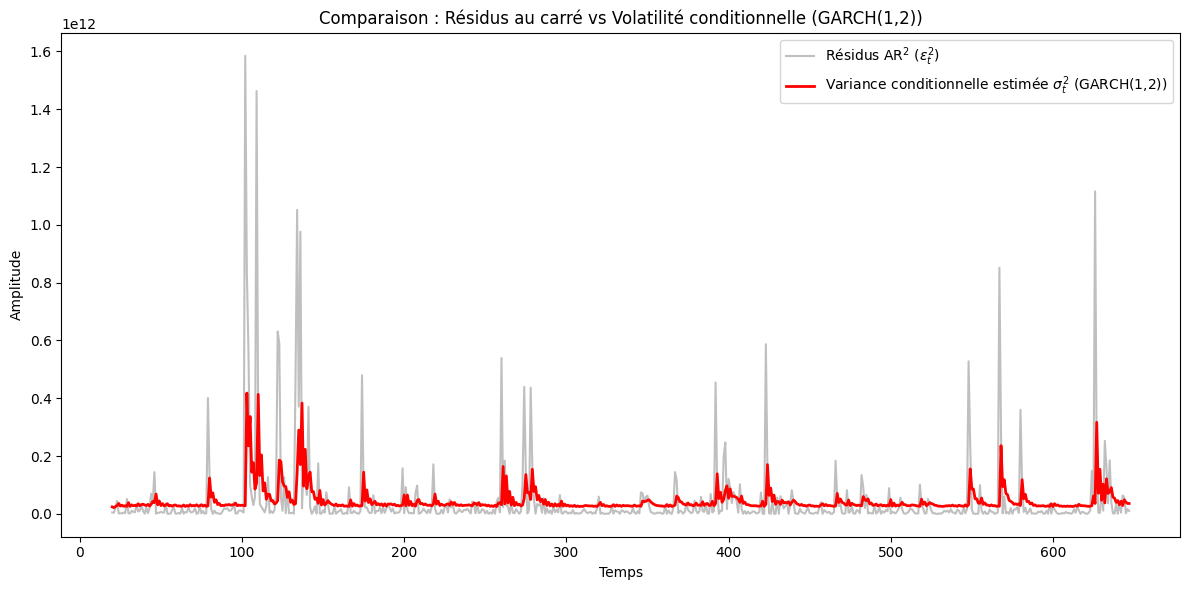

In [112]:
import matplotlib.pyplot as plt

# Variance conditionnelle estimée par le GARCH choisi
sigma2_t = fits[best_model].conditional_volatility**2  

# Résidus au carré (issus du AR)
resid_sq = resid**2

# ================================
# Graphique : σ_t² vs ε_t²
# ================================
plt.figure(figsize=(12,6))
plt.plot(resid_sq, color="grey", alpha=0.5, label=r"Résidus AR$^2$ ($\varepsilon_t^2$)")
plt.plot(sigma2_t, color="red", linewidth=2, label=fr"Variance conditionnelle estimée $\sigma_t^2$ ({best_model})")

plt.title(f"Comparaison : Résidus au carré vs Volatilité conditionnelle ({best_model})")
plt.xlabel("Temps")
plt.ylabel("Amplitude")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# 14. Graphique de l'estimation de GARCH des résidus

In [99]:
fc = garch_final.forecast(horizon=len(y_test))

# Prévision de la moyenne conditionnelle (point forecast)
pred_test = fc.mean.iloc[-1]
pred_test.index = y_test.index

# Prévision de la variance conditionnelle (volatilité)
sigma_test = np.sqrt(fc.variance.iloc[-1])
sigma_test.index = y_test.index

Le graphique compare les résidus au carré du modèle AR(20) (courbe grise, très bruitée) et la variance conditionnelle estimée par le GARCH(1,2) (courbe rouge lissée).

On observe que :
- Les pics des résidus au carré correspondent à des périodes de forte volatilité.
- Le GARCH(1,2) ne suit pas chaque pic isolé, mais il capte l’intensité globale de la volatilité :
-- lorsque de grands chocs apparaissent, la variance conditionnelle estimée augmente,
-- lorsqu’il n’y a pas de chocs, la variance diminue.

La courbe rouge agit comme une enveloppe lissée des fluctuations grises, ce qui correspond exactement au rôle d’un modèle GARCH : modéliser la dynamique de la variance conditionnelle sans reproduire le bruit.

# 15. AR + GARCH en graphique

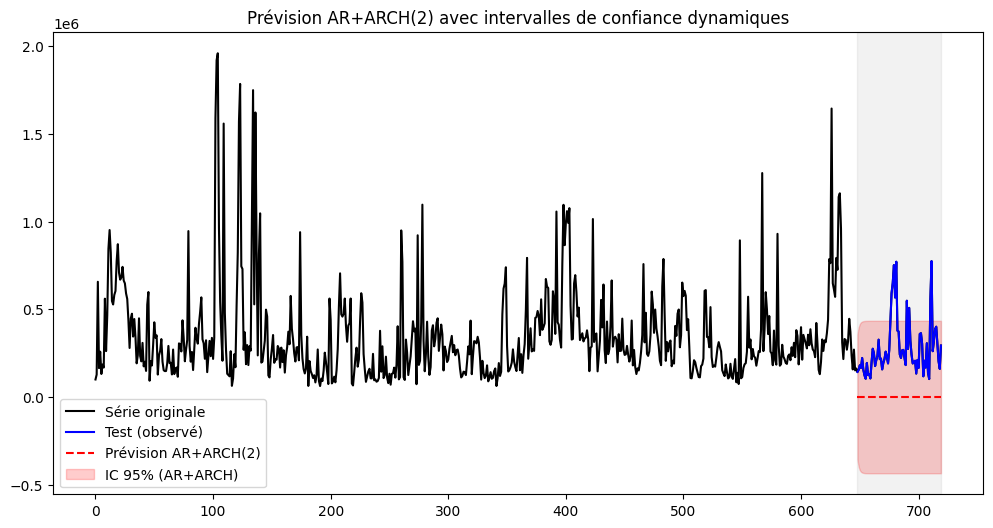

In [113]:
# ================================
# Prévision avec AR + ARCH intégré
# ================================
h = len(y_test)

# forecast depuis le modèle AR+ARCH final
fc = arch_final.forecast(horizon=h)

# Prévision de la moyenne conditionnelle (point forecast)
pred_mean = fc.mean.iloc[-1]
pred_mean.index = y_test.index

# Prévision de la variance conditionnelle
pred_var = fc.variance.iloc[-1]
pred_sigma = np.sqrt(pred_var)
pred_sigma.index = y_test.index

# IC 95%
upper = pred_mean + 2*pred_sigma
lower = pred_mean - 2*pred_sigma

# ================================
# Visualisation
# ================================
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y, color="black", label="Série originale")
plt.plot(y_test, color="blue", label="Test (observé)")
plt.plot(pred_mean, color="red", linestyle="--", label="Prévision AR+ARCH(2)")
plt.fill_between(y_test.index, lower, upper, color="red", alpha=0.2,
                 label="IC 95% (AR+ARCH)")
plt.axvspan(y_test.index[0], y_test.index[-1], color="grey", alpha=0.1)
plt.legend()
plt.title("Prévision AR+ARCH(2) avec intervalles de confiance dynamiques")
plt.show()

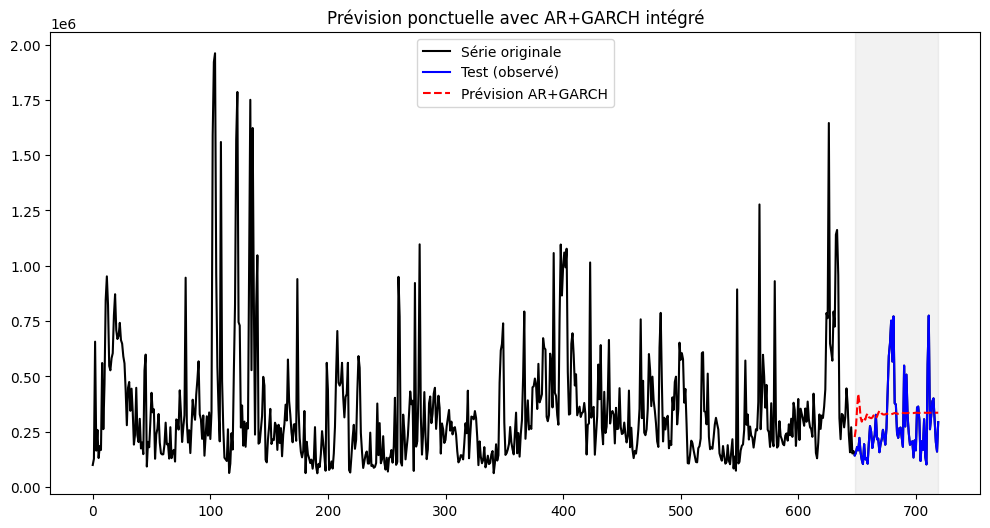

In [101]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y, color="black", label="Série originale")
plt.plot(y_test, color="blue", label="Test (observé)")
plt.plot(pred_mean, color="red", linestyle="--", label="Prévision AR+GARCH")
plt.axvspan(y_test.index[0], y_test.index[-1], color="grey", alpha=0.1)
plt.legend()
plt.title("Prévision ponctuelle avec AR+GARCH intégré")
plt.show()
